### Siyu Ma
#### Financial Data Science
#### Project

This python project aims to predict Netflix stock price based on historical stock price data using Time Series Models.<br>

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np 
import pandas as pd 
import os
import math
import yfinance as yf
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
warnings.filterwarnings('ignore')

### Import and read data from yahoo finance

In [ ]:
stock = 'NFLX'
start = datetime.datetime(2002,5,23)
end = datetime.datetime(2021,10,20)
nflx = yf.download(stock,start=start,end=end,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
nflx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
nflx.shape

(4887, 6)

In [ ]:
nflx_close = yf.download(stock,start=start,end=end,interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
nflx_close.head()

Date
2002-05-23    1.196429
2002-05-24    1.210000
2002-05-28    1.157143
2002-05-29    1.103571
2002-05-30    1.071429
Name: Close, dtype: float64

In [ ]:
nflx_close.describe()

count    4887.000000
mean      106.080998
std       158.057493
min         0.372857
25%         3.907857
50%        21.878571
75%       125.739998
max       639.099976
Name: Close, dtype: float64

### Visualize the Netflix Stock Price 

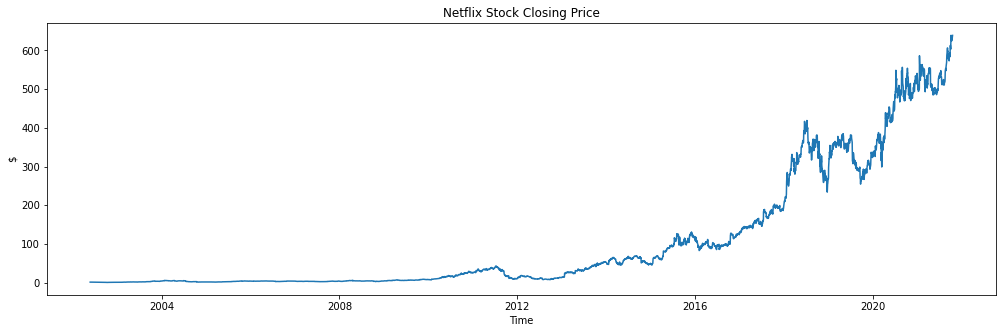

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(nflx_close)
plt.title('Netflix Stock Closing Price')
plt.ylabel('$')
plt.xlabel('Time')
plt.show()

- We can see there is a increasing trend in Netflix'stock price. In 2012, it has a value under $\$100$ USD; And it hits $\$600$ USD in 2021. This trend also indicates the time series is not stationary.


### Check stationarity

#### ADF test

In [ ]:
stat_test = adfuller(nflx_close)[:2]
print('ADF Statistic: %f' % stat_test[0])
print('P-value: %f' % stat_test[1])

ADF Statistic: 3.103854
P-value: 1.000000


- Since the p-value is greater than the significance level(0.05), hence the time series is not stationary. We need to take the first-order difference to check the autocorrelation.

### Autocorrelation Function(ACF)

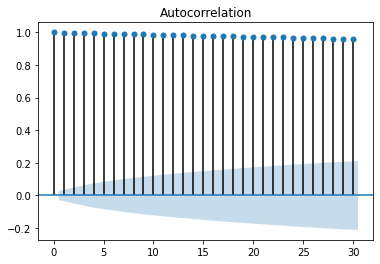

In [ ]:
# acf test
sm.graphics.tsa.plot_acf(nflx_close,lags=30)
plt.show()

- The acf is slowlying decaying, hence the time series is not stationary. So we need to take the first-order differencing.

#### Take the first-order difference

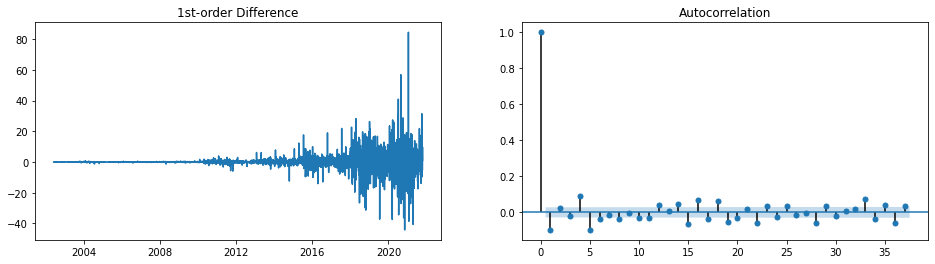

In [ ]:
diff_nflx_close = nflx_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('1st-order Difference')
sm.graphics.tsa.plot_acf(diff_nflx_close, ax=ax2);

- After the 1st order differencing, the differenced time series is stationary.

#### Partial correlation plot

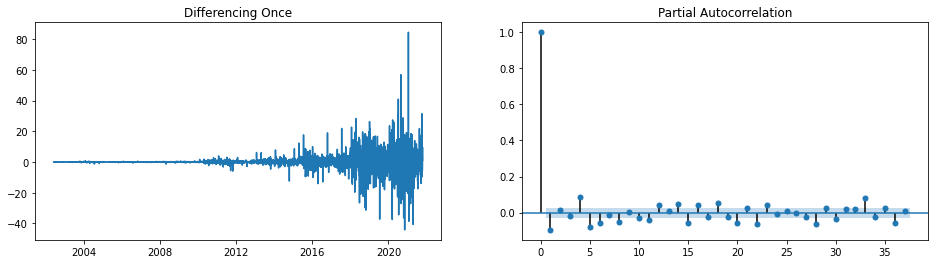

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('Differencing Once')
sm.graphics.tsa.plot_pacf(diff_nflx_close, ax=ax2)
plt.show()

- The PACF lag 5 is significant because it spikes up over the significant line. Hence, we get "p = 5".

### Use ACF plot to get the parameter for q.
- q is the order of the Moving Average term. 

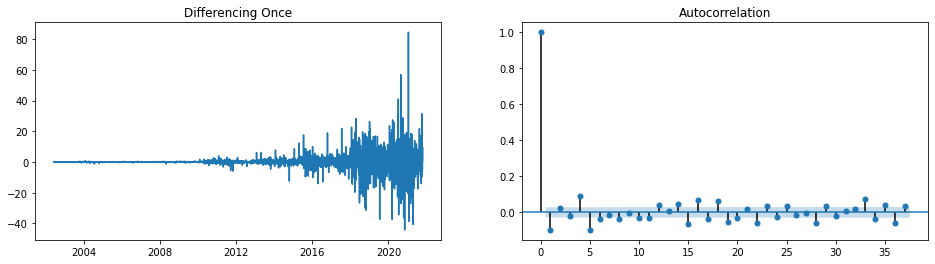

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('Differencing Once')
sm.graphics.tsa.plot_acf(diff_nflx_close, ax=ax2)
plt.show()

- From the ACF plot, we can choose "q = 5".

### Separating trend and seasonality from the time series for Netflix stock price.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

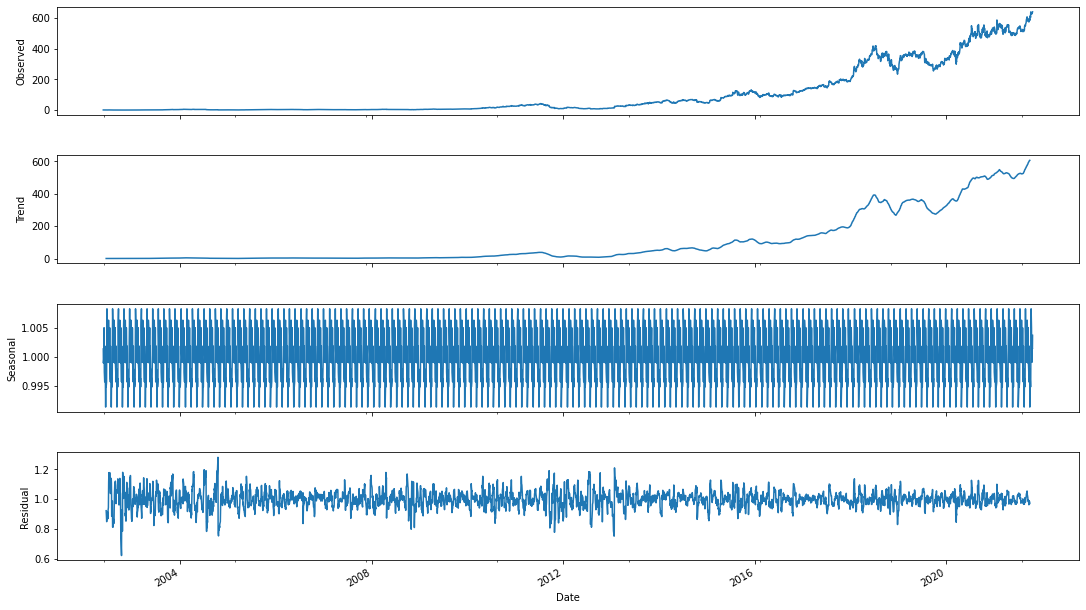

In [ ]:
result = seasonal_decompose(nflx_close, model='multiplicative', freq = 30)
fig = result.plot()  
fig.set_size_inches(17, 10)
plt.show()

- We can see that there is a clear upward trend in the series. And the seasonal change is uniformed. The residuals are not uniformed. Seasonality and residuals are centered at one. 

### Time Series Model

### Building the final model

- Instead of using the first differencing method, we can try to use the log of the series. It can help with removing trend.
- We could get the rolling average of the series to see the mean consumption values.

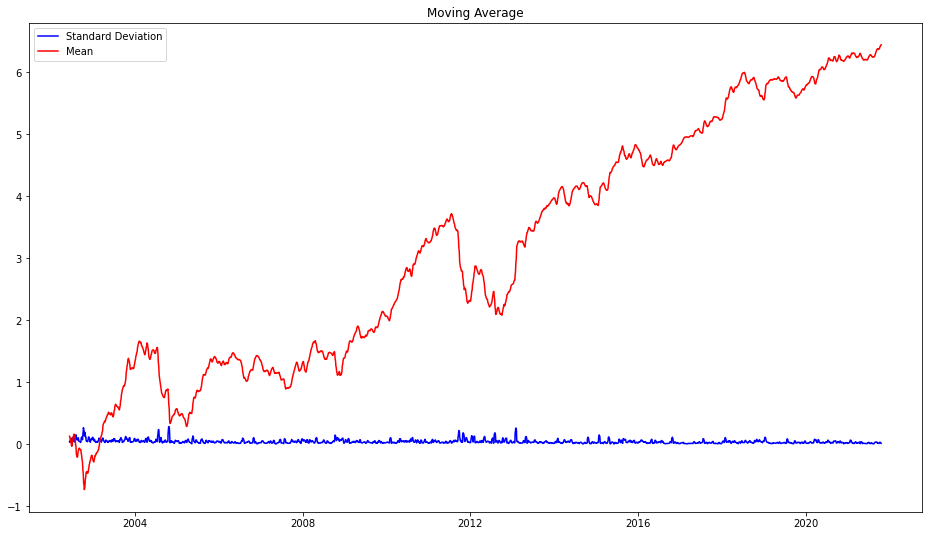

In [ ]:
nflx_log = np.log(nflx_close)

moving_avg = nflx_log.rolling(12).mean()
std_dev = nflx_log.rolling(12).std()

plt.title('Moving Average')
plt.plot(std_dev, color ="b", label = "Standard Deviation")
plt.plot(moving_avg, color="r", label = "Mean")
plt.legend()
plt.show()

Text(0, 0.5, 'price')

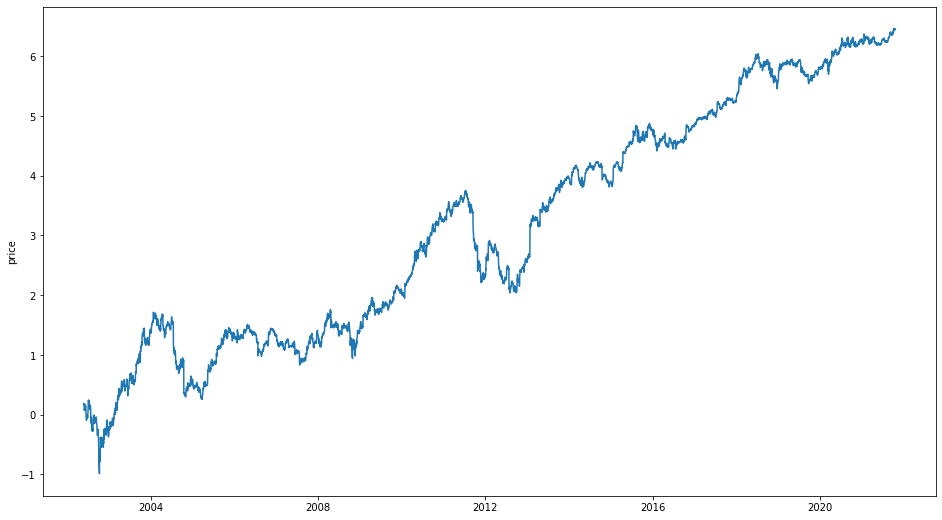

In [ ]:
plt.plot(nflx_log)
plt.ylabel('price')

###  Split the time series data to training and testing set.

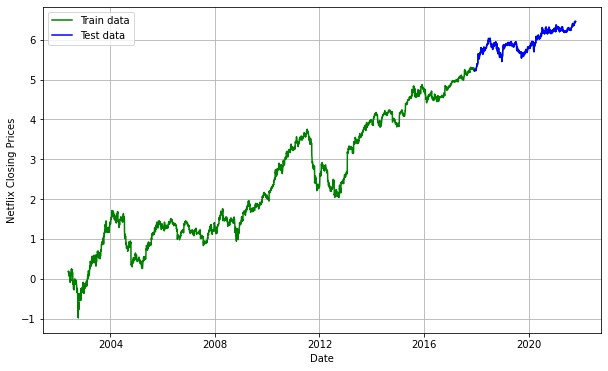

In [ ]:
# split data into train and training set
# training set 80%, testing set 0%

train_data, test_data = nflx_log[1:int(len(nflx_log)*0.8)], nflx_log[int(len(nflx_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Netflix Closing Prices')
plt.plot(nflx_log,'g',label='Train data')
plt.plot(test_data,'b',label='Test data')
plt.legend();


### Modeling

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model_nflx = ARIMA(train_data, order=(5, 1, 5))
model_fitted = model_nflx.fit(disp=0)
print(model_fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3907
Model:                 ARIMA(5, 1, 5)   Log Likelihood                7245.483
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 04 Jan 2022   AIC                         -14466.966
Time:                        04:43:16   BIC                         -14391.720
Sample:                             1   HQIC                        -14440.261
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      1.854      0.064   -7.31e-05       0.003
ar.L1.D.Close    -0.1654      0.349     -0.474      0.636      -0.850       0.519
ar.L2.D.Close     0.7630      0.314     

### Prediction 
- We will use 95% confidence interval in this case.

In [ ]:
fc, se, conf = model_fitted.forecast(978, alpha=0.05)

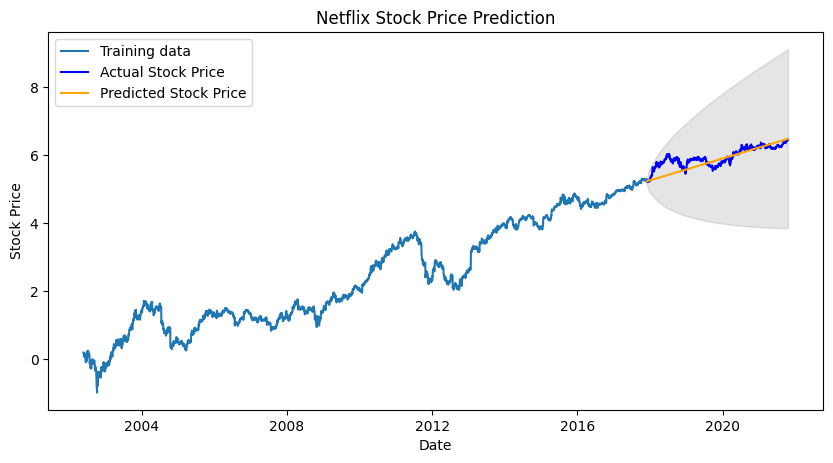

In [ ]:
fitted_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fitted_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.show()

- From the plot we can see that the forecasting data and prediction data are matching.

In [ ]:
mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE:', mape)

MSE:  0.04846108800756768
MAPE: 0.02845564581783305


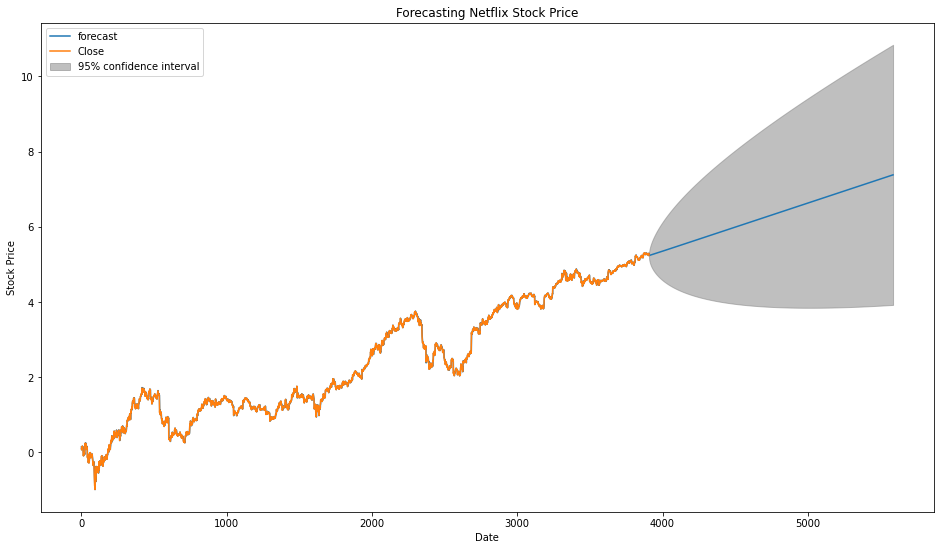

In [ ]:
model_fitted.plot_predict(start=2, end=len(nflx_close)+700)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.title('Forecasting Netflix Stock Price')
plt.show()

- MSE is really small in this case, and MAPE as 2.8% means that 97.2% accurate in predicting the testing data.

### Results and discussion

- From the results, I used ARIMA(5, 1, 5) with constant to predict the Netflix stock price data. The model fit and accuracy showed good feedback. 
- From this project, I realized that those Time Series models we learned from class are mainly used for predicting based on historical data. I have limited time to finish the part for forecasting future stock price. For future study, I will work on testing different models other than time series models on this dataset, and apply other methods to forecast future stock price trend (e.g. machine learning models). <br>